In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from utils import *
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.metrics import silhouette_score


In [2]:
colors = [
    "#fcf444",  # light yellow/pastel yellow
    "#84fc04",  # lime green / neon green
    "#84b4b4",  # blue-green
    "#340cfc",  # deep blue / electric blue
    "#046ccc",  # cyan blue
    "#c0fcfc",  # light cyan
    "#88fcfc",  # very light cyan / soft turquoise
    "#6cb4cc",  # light sky blue / light cerulean blue
    "#dc1cfc",  # bright magenta / electric purple
    "#1005bc",  # deep blue
    "#dedede",  # light gray
    "#fc0c34"   # gainsboro
]

lithology = [
    "Sandstone (Arenito)",
    "Sandstone/Shale (Arenito)",
    "Shale (Argilito)",
    "Marl (Marga)",
    "Dolomite (Dolomita)",
    "Limestone (Calcário)",  
    "Chalk (Giz)",
    "Halite (Halita)",
    "Anhydrite (Anidrita)",
    "Tuff (Tufo)",
    "Coal (Carvão)",
    "Basement (Substrato)" 
]

In [3]:
#Carregando conjunto de dados   
dataset = pd.read_csv('Dados/train_dataset_proc.csv')
dataset.head()

,Unnamed: 0,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,...,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_num,FORMATION_num,LITHOLOGY,RMED_log,RDEP_log
0,4238,15/9-13,1138.704,437640.84375,6470976.0,-1113.655396,NORDLAND GP.,Utsira Fm.,19.322735,1.013309,...,55.892757,0.765867,147.837677,30000,1.0,6,67,Sandstone (Arenito),0.005742,0.038023
1,4239,15/9-13,1138.856,437640.84375,6470976.0,-1113.807373,NORDLAND GP.,Utsira Fm.,18.613674,1.088184,...,60.929138,0.800262,142.382431,65000,1.0,6,67,Shale (Argilito),0.036703,0.050266
2,4240,15/9-13,1139.008,437640.84375,6470976.0,-1113.959473,NORDLAND GP.,Utsira Fm.,18.212072,1.127155,...,62.117264,0.765957,138.258331,65000,1.0,6,67,Shale (Argilito),0.051984,0.059995
3,4241,15/9-13,1139.160,437640.84375,6470976.0,-1114.111450,NORDLAND GP.,Utsira Fm.,18.134182,1.141467,...,61.010860,0.702521,139.198914,65000,1.0,6,67,Shale (Argilito),0.057463,0.068551
4,4242,15/9-13,1139.312,437640.84375,6470976.0,-1114.263428,NORDLAND GP.,Utsira Fm.,18.033762,1.138007,...,58.501236,0.639708,144.290085,65000,1.0,6,67,Shale (Argilito),0.056145,0.073381


In [4]:
#Plotando perfis de poços
@interact(well=dataset.WELL.unique())
def update_well_plot(well):
    plot_well_logs(dataset, well=well,lithology_col='LITHOLOGY',colors=colors,lithology=lithology,dz=100)

interactive(children=(Dropdown(description='well', options=('15/9-13', '15/9-15', '16/1-2', '16/1-6 A', '16/10…

In [5]:
dataset.columns

Index(['Unnamed: 0', 'WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP',
       'FORMATION', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC',
       'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE',
       'GROUP_num', 'FORMATION_num', 'LITHOLOGY', 'RMED_log', 'RDEP_log'],
      dtype='object')

In [51]:
#Selecionando colunas para realizar a clusterização dos dados
cols = ['GROUP_num', 'RHOB','GR', 'NPHI', 'DTC', 'RDEP_log','RMED_log']
X = dataset[dataset.WELL=='25/11-5']

In [52]:
X.head()

,Unnamed: 0,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RMED,...,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_num,FORMATION_num,LITHOLOGY,RMED_log,RDEP_log
138024,221082,25/11-5,1388.144719,463756.0,6562935.0,-1364.644775,HORDALAND GP.,Skade Fm.,12.078982,0.766836,...,51.836914,0.643898,154.746155,65000,2.0,5,50,Shale (Argilito),-0.115297,-0.164510
138025,221083,25/11-5,1388.296719,463756.0,6562935.0,-1364.796753,HORDALAND GP.,Skade Fm.,12.078423,0.772953,...,51.719269,0.636912,152.548431,65000,2.0,5,50,Shale (Argilito),-0.111847,-0.176380
138026,221084,25/11-5,1388.448719,463756.0,6562935.0,-1364.948730,HORDALAND GP.,Skade Fm.,12.093619,0.778810,...,51.867138,0.635683,154.109756,65000,2.0,5,50,Shale (Argilito),-0.108569,-0.178692
138027,221085,25/11-5,1388.600719,463756.0,6562935.0,-1365.100708,HORDALAND GP.,Skade Fm.,12.009061,0.783238,...,51.899590,0.654904,156.116776,65000,2.0,5,50,Shale (Argilito),-0.106107,-0.175278
138028,221086,25/11-5,1388.752719,463756.0,6562935.0,-1365.252686,HORDALAND GP.,Skade Fm.,11.849934,0.785557,...,52.132004,0.692619,155.994278,65000,2.0,5,50,Shale (Argilito),-0.104822,-0.172558


In [53]:
#Objeto para normalização dos dados
scaler = StandardScaler()

In [54]:
km = KMeans(n_clusters=4)
km.fit(scaler.fit_transform(X[cols]))

X['km_label'] = km.labels_

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Acer3\AppData\Local\Temp\ipykernel_11956\2740434404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['km_label'] = km.labels_


(<Figure size 1100x1200 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

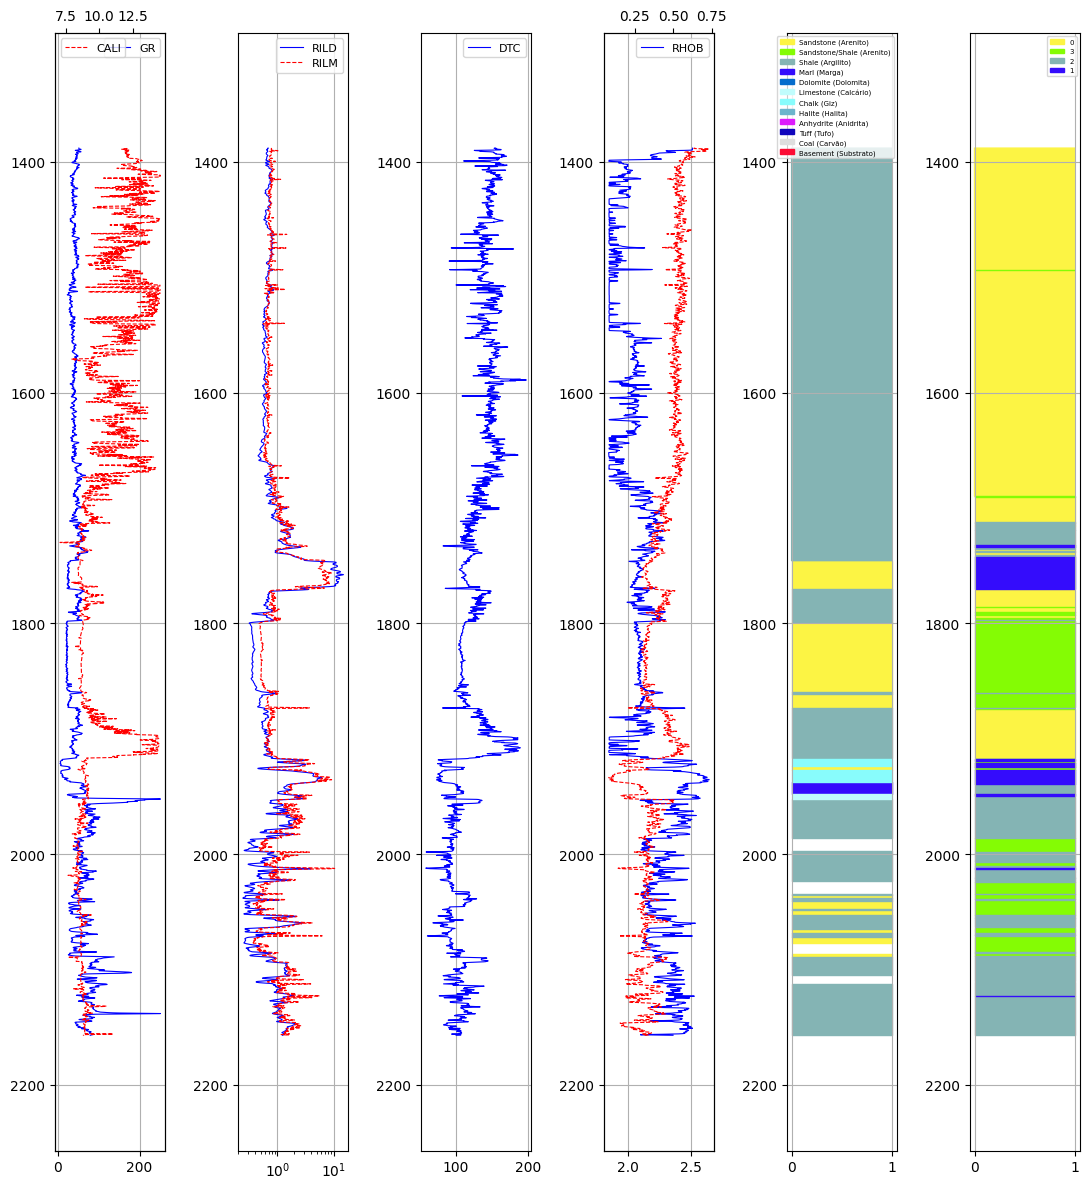

In [55]:
plot_well_logs_comparison_cluster(X, well=X.WELL.unique()[0],lithology_col='LITHOLOGY',colors=colors,lithology=lithology,predicted_col='km_label',dz=100)

In [56]:
#Calculando o índice de Davies-Bouldin
from sklearn.metrics import davies_bouldin_score

In [57]:
#Calculando o coeficiente de silhueta para diferentes números de clusters
sil = []
var_intra_cluster = []
db_score = []

for i in range(2, 13):
    km = KMeans(n_clusters=i,n_init='auto')
    km.fit(scaler.fit_transform(X[cols]))
    sil.append(silhouette_score(X[cols], km.labels_))
    db_score.append(davies_bouldin_score(scaler.fit_transform(X[cols]), km.labels_))
    var_intra_cluster.append(km.inertia_)

Text(0, 0.5, 'índice de Davies-Bouldin')

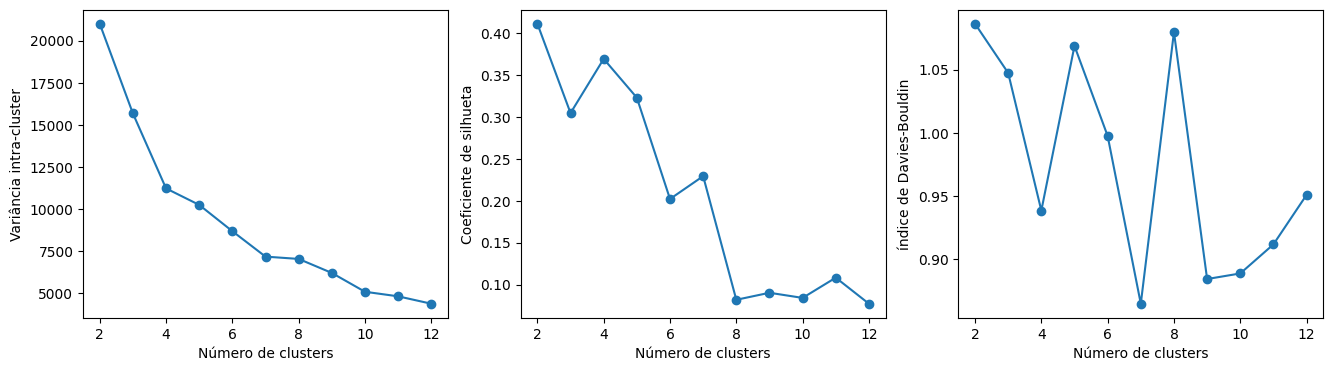

In [58]:
fig, axes = plt.subplots(ncols=3,figsize=(16, 4))

#Plotando o gráfico elbow
axes[0].plot((np.arange(2,13)),var_intra_cluster,marker='o')
axes[0].set_xlabel('Número de clusters')
axes[0].set_ylabel('Variância intra-cluster')


#Plotando os valores do índice de silhueta
axes[1].plot(np.arange(2,13),sil,marker='o')
axes[1].set_xlabel('Número de clusters')
axes[1].set_ylabel('Coeficiente de silhueta')

#Plotando o índice de Davies-Bouldin

axes[2].plot((np.arange(2,13)),db_score,marker='o')
axes[2].set_xlabel('Número de clusters')
axes[2].set_ylabel('índice de Davies-Bouldin')


In [60]:
#Realizando a clusterização com 5 clusters
km = KMeans(n_clusters=8)
km.fit(scaler.fit_transform(X[cols]))

X['km_label_5'] = km.labels_

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Acer3\AppData\Local\Temp\ipykernel_11956\2668410140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['km_label_5'] = km.labels_


(<Figure size 1100x1200 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

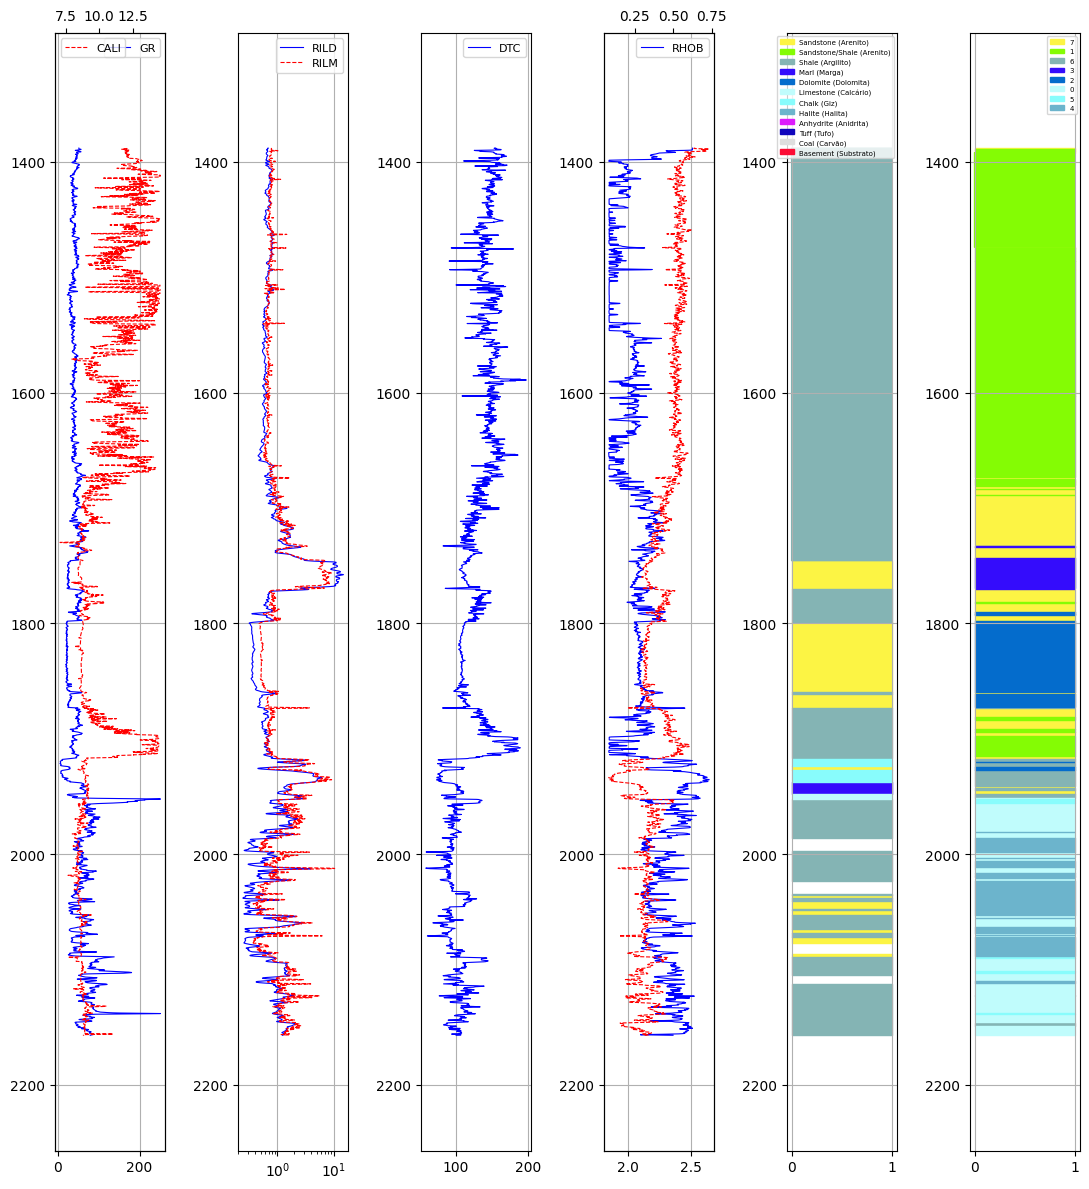

In [61]:
plot_well_logs_comparison_cluster(X, well=X.WELL.unique()[0],lithology_col='LITHOLOGY',colors=colors,lithology=lithology,predicted_col='km_label_5',dz=100)